<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов
**Заполните код в клетках и выберите ответы в [веб-форме](https://docs.google.com/forms/d/1l3OtddjlKGGyl285bkzu4ulH5cXSnBdAkqR9VzB3Bgg/edit).**

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.2.2


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df.date = pd.to_datetime(df.date)

In [5]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [8]:
## ВАШ КОД для построения модели ##

m = Prophet()
m.fit(train_df)
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)
forecast.tail()

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
378,2016-01-16,2979.025814,2960.096559,2999.917111,1730.842212,2525.471947,-861.719253,-861.719253,-861.719253,-861.719253,-861.719253,-861.719253,-861.719253,-861.719253,-861.719253,2117.306561
379,2016-01-17,2984.428244,2964.589812,3006.205451,1874.644606,2664.322421,-720.703874,-720.703874,-720.703874,-720.703874,-720.703874,-720.703874,-720.703874,-720.703874,-720.703874,2263.724370
380,2016-01-18,2989.830675,2968.027718,3012.753922,2850.564248,3710.888243,281.391058,281.391058,281.391058,281.391058,281.391058,281.391058,281.391058,281.391058,281.391058,3271.221733
381,2016-01-19,2995.233106,2972.257869,3019.894501,3119.546290,3955.258755,541.447205,541.447205,541.447205,541.447205,541.447205,541.447205,541.447205,541.447205,541.447205,3536.680311
382,2016-01-20,3000.635537,2976.314453,3026.920430,3022.465507,3840.651902,425.560146,425.560146,425.560146,425.560146,425.560146,425.560146,425.560146,425.560146,425.560146,3426.195682


**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.
 3001
 
Оценим качество предсказания по последним 30 точкам.

In [9]:
## ВАШ КОД для оценки качества полученной модели ##
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(34.49241768741889, 599.6208232990795)

**Вопрос 2**: Какое получилось MAPE?
cмотри выше

**Вопрос 3**: Какое получилось MAE? смотри выше


## Предсказываем с помощью ARIMA

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

/home/yulia/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

Критерий Дики-Фуллера: p=0.107392


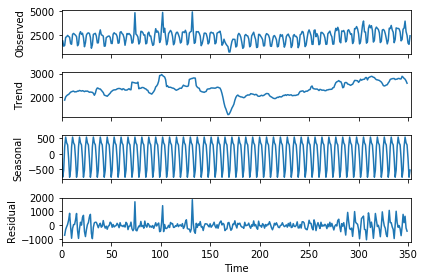

In [11]:
## ВАШ КОД для проверки стационарности ряда ##
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [20]:
train_df['y_box'], lmbda = stats.boxcox(train_df.y+1)


In [14]:
result_table = pd.DataFrame(results)
print(result_table)

Empty DataFrame
Columns: []
Index: []


In [16]:
print(best_model.summary())

NameError: name 'best_model' is not defined

In [37]:
train_df.head()


,ds,y,y_box
81,2015-01-01,1414,276.458939
80,2015-01-02,1920,346.274243
79,2015-01-03,1338,265.435365
78,2015-01-04,1404,275.017684
77,2015-01-05,2264,390.902181
